# Inference and Visualization Tutorial

Welcome to the inference and visualization notebook! At this point, you should have a trained model and tiles to run inference. In this notebook we will run inference on a slide and visualize the results. Here are the steps we will review:

- Run inference with a trained model.
- Visualize the inference results

## Run inference with a trained model

Often tissue-based analysis on whole slide images benefit from annotations provided by expert pathologists. However, having pathologists annotate 1000s of slides is very time consuming and expensive. To overcome this bottleneck, it is common to have pathologist annotate a subset of the slides, and use that dataset to train a model. This model is then used to label the rest of the dataset.

In the model training notebook, we trained a ResNet-18 model on a subset of our slides with the annotated regions and labels. We will now use this trained model and the prepared tiles from the test slide to run the inference step.

In [2]:
# TEMP
%env LUNA_HOME=/Users/rosed2/Documents/msk-mind/luna
%env PYTHONPATH=/Users/rosed2/Documents/msk-mind/luna/pyluna-pathology:/Users/rosed2/Documents/msk-mind/luna/pyluna-common:.


env: LUNA_HOME=/Users/rosed2/Documents/msk-mind/luna
env: PYTHONPATH=/Users/rosed2/Documents/msk-mind/luna/pyluna-pathology:/Users/rosed2/Documents/msk-mind/luna/pyluna-common:.


In [7]:
!infer_tiles --help

2022-04-04 15:07:49,991 - INFO - root - FYI: Initalized logger, log file at: data-processing.log with handlers: [<StreamHandler <stderr> (INFO)>, <RotatingFileHandler /Users/rosed2/Documents/msk-mind/luna/docker/luna_tutorial/vmount/notebooks/data-processing.log (INFO)>]
Usage: infer_tiles [OPTIONS] INPUT_SLIDE_TILES

  Run a model with a specific pre-transform for all tiles in a slide
  (tile_images), requires tiles to be saved (save_tiles) first

  Inputs:
      input_slide_tiles: path to tile images (.tiles.csv)
  
  Outputs:
      tile_scores
  
  Example:
      infer_tiles tiles/slide-100012/tiles
          -rn msk-mind/luna-ml:main
          -mn tissue_tile_net_model_5_class
          -tn tissue_tile_net_transform
          -wt main:tissue_net_2021-01-19_21.05.24-e17.pth
          -o tiles/slide-100012/scores

Options:
  -o, --output_dir TEXT         path to output directory to save results
  -rn, --hub_repo_or_dir TEXT   repository name to pull model and weight from,
         

**infer_tiles** CLI takes in details on your trained model, and loads the tiles data for inference.

In [18]:
#!cat ../PRO-12-123/tables/tiles/01OV008-7579323e-2fae-43a9-b00f-a15c28/ov_default_labels/TileImages/data/address.slice.csv

# Copied pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/
!cat ../PRO-12-123/sample_tiles/123.tiles.csv

address,x_coord,y_coord,xy_extent,tile_size,tile_units,tile_store
x1_y1_z10.0,512,512,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x1_y2_z10.0,512,1024,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x1_y3_z10.0,512,1536,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x1_y4_z10.0,512,2048,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x2_y1_z10.0,1024,512,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x2_y2_z10.0,1024,1024,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x2_y3_z10.0,1024,1536,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x2_y4_z10.0,1024,2048,512,256,px,pyluna-pathology/tests/luna/pathology/cli/testdata/data/save_tiles/123/123.tiles.h5
x3_y

In [20]:
!infer_tiles ../PRO-12-123/sample_tiles/123.tiles.csv \
--output_dir ../PRO-12-123/sample_tiles_inference \
--hub_repo_or_dir ../classifier \
--model_name test_custom_model \
#--model_name tissue_tile_net_model_5_class \
--num_cores 1 \
--batch_size 16
        

2022-04-04 15:58:01,312 - INFO - root - FYI: Initalized logger, log file at: data-processing.log with handlers: [<StreamHandler <stderr> (INFO)>, <RotatingFileHandler /Users/rosed2/Documents/msk-mind/luna/docker/luna_tutorial/vmount/notebooks/data-processing.log (INFO)>]
2022-04-04 15:58:01,313 - INFO - luna.common.utils - Running <function infer_tile_labels at 0x16239e940> with {'output_dir': '../PRO-12-123/sample_tiles_inference', 'hub_repo_or_dir': '../classifier', 'model_name': 'test_custom_model', 'input_slide_tiles': '../PRO-12-123/sample_tiles/123.tiles.csv', 'transform_name': None, 'kwargs': {}, 'num_cores': 4, 'batch_size': 64, 'method_param_path': None}
2022-04-04 15:58:01,313 - INFO - luna.common.utils - Param input_slide_tiles set = ../PRO-12-123/sample_tiles/123.tiles.csv
2022-04-04 15:58:01,313 - INFO - luna.common.utils - Param output_dir set = ../PRO-12-123/sample_tiles_inference
2022-04-04 15:58:01,313 - INFO - luna.common.utils - Param hub_repo_or_dir set = ../classif

The output of the inference is saved in a CSV. Let's take a look at the results.

In [21]:
!ls -lhtr ../PRO-12-123/sample_tiles_inference 

total 16
-rw-r--r--  1 rosed2  MSKCC\Domain Users   1.2K Apr  4 15:58 tile_scores_and_labels_pytorch_inference.csv
-rw-r--r--  1 rosed2  MSKCC\Domain Users   446B Apr  4 15:58 metadata.yml


Note that for the purpose of the tutorials, we are working with a small toy dataset, and therefore the inference result is not optimal. This result is for demonstration purposes only.

In [23]:
import pandas as pd

results = pd.read_csv("../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.csv")
results

,address,x_coord,y_coord,xy_extent,tile_size,tile_units,tile_store,Background,Tumor
0,x1_y1_z10.0,512,512,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.162288,1.159485
1,x1_y2_z10.0,512,1024,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.151000,1.070280
2,x1_y3_z10.0,512,1536,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.146432,1.033477
3,x1_y4_z10.0,512,2048,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.136010,0.933327
4,x2_y1_z10.0,1024,512,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.098171,0.691738
5,x2_y2_z10.0,1024,1024,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.090072,0.663284
6,x2_y3_z10.0,1024,1536,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.091160,0.654910
7,x2_y4_z10.0,1024,2048,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.107406,0.732663
8,x3_y1_z10.0,1536,512,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.158197,1.147173
9,x3_y2_z10.0,1536,1024,512,256,px,../PRO-12-123/sample_tiles/123.tiles.h5,-0.135955,1.007193


## Visualize the inference results

Now we will visualize the inference results. **visualize_tiles_ng** CLI creates heatmaps based on the scores, and saves the thumbnail images in png format.


In [27]:
!visualize_tiles_png --help

2022-04-04 16:05:18,158 - INFO - root - FYI: Initalized logger, log file at: data-processing.log with handlers: [<StreamHandler <stderr> (INFO)>, <RotatingFileHandler /Users/rosed2/Documents/msk-mind/luna/docker/luna_tutorial/vmount/notebooks/data-processing.log (INFO)>]
Usage: visualize_tiles_png [OPTIONS] INPUT_SLIDE_IMAGE INPUT_SLIDE_TILES

  Generate nice tile markup images with continuous or discrete tile scores

  Inputs:
      input_slide_image: slide image (virtual slide formats compatible with openslide, .svs, .tif, .scn, ...)
      input_slide_tiles: slide tiles (manifest tile files, .tiles.csv)
 
  Outputs:
      markups: markup images
 
  Example:
      visualize_tiles_png 10001.svs 10001/tiles/10001.tiles.csv
          -o 10001/markups
          -pl Tumor,Stroma,TILs,otsu_score
          -rmg 0.5

Options:
  -o, --output_dir TEXT           path to output directory to save results
  -pl, --plot_labels TEXT         Label names (as column labels) to plot
  -rmg, --requested_m

If you want to evaluate your model results in detail, it is desirable to review the results and images in high-magnification.
We use [Digital Slide Archive (DSA)](https://digitalslidearchive.github.io/digital_slide_archive/) viewer to examine the high resolution image and results. DSA is a web-based platform and this enables us to easily share the images and model results with other researchers via a link.

A set of CLIs are available to help you convert your pathologist or model-generated annotations and push them to DSA. Please refer to the `dsa-tools.ipynb` notebook for more details.


In [8]:
!visualize_tiles_png \
../PRO-12-123/123.svs \
../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.csv \
--output_dir ../PRO-12-123/sample_tiles_viz \
--plot_labels Background,Tumor \
--requested_magnification 1


2022-04-05 08:07:23,436 - INFO - root - FYI: Initalized logger, log file at: data-processing.log with handlers: [<StreamHandler <stderr> (INFO)>, <RotatingFileHandler /Users/rosed2/Documents/msk-mind/luna/docker/luna_tutorial/vmount/notebooks/data-processing.log (INFO)>]
2022-04-05 08:07:24,597 - INFO - luna.common.utils - Running <function visualize_tiles at 0x11f211ca0> with {'output_dir': '../PRO-12-123/sample_tiles_viz', 'plot_labels': 'Background,Tumor', 'requested_magnification': '1', 'input_slide_image': '../PRO-12-123/123.svs', 'input_slide_tiles': '../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.csv', 'mpp_units': False, 'method_param_path': None}
2022-04-05 08:07:24,597 - INFO - luna.common.utils - Param input_slide_image set = ../PRO-12-123/123.svs
2022-04-05 08:07:24,597 - INFO - luna.common.utils - Param input_slide_tiles set = ../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.csv
2022-04-05 08:07:24,597 - INFO - lu

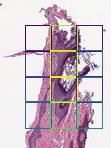

In [9]:
from IPython.display import Image

Image('../PRO-12-123/sample_tiles_viz/tile_scores_and_labels_visualization_Background.png')

Congratulations on completing the inference and visualization notebook! To view the end-to-end pipeline of the tiling workflow, please checkout the end-to-end notebook.